This notebook gives intuition about the basics of Bayesian inference. This first example is borrowed from Cam Davidson-Pilon's online book, Probabilistic Programming & Bayesian Methods for Hackers (https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers)

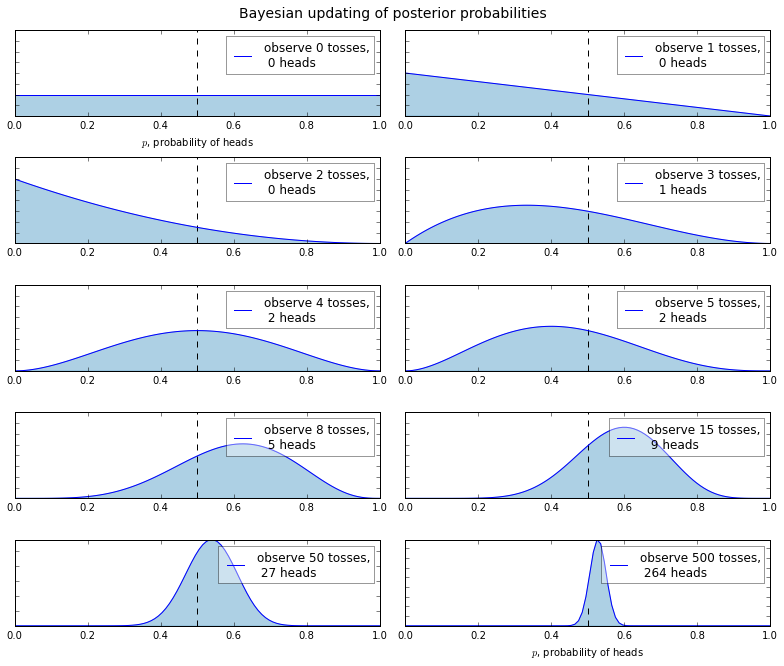

In [1]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
figsize(11, 9)

import scipy.stats as stats

dist = stats.beta
n_trials = [0, 1, 2, 3, 4, 5, 8, 15, 50, 500]
data = stats.bernoulli.rvs(0.5, size=n_trials[-1])
x = np.linspace(0, 1, 100)

# For the already prepared, I'm using Binomial's conj. prior.
for k, N in enumerate(n_trials):
    sx = plt.subplot(len(n_trials) / 2, 2, k + 1)
    plt.xlabel("$p$, probability of heads") \
        if k in [0, len(n_trials) - 1] else None
    plt.setp(sx.get_yticklabels(), visible=False)
    heads = data[:N].sum()
    y = dist.pdf(x, 1 + heads, 1 + N - heads)
    plt.plot(x, y, label="observe %d tosses,\n %d heads" % (N, heads))
    plt.fill_between(x, 0, y, color="#348ABD", alpha=0.4)
    plt.vlines(0.5, 0, 4, color="k", linestyles="--", lw=1)

    leg = plt.legend()
    leg.get_frame().set_alpha(0.4)
    plt.autoscale(tight=True)


plt.suptitle("Bayesian updating of posterior probabilities",
             y=1.02,
             fontsize=14)

plt.tight_layout()

Now let's look at the relation of classical and Bayesian inference, in the context of linear regression. This presentation borrows heavily from http://www.stats.ox.ac.uk/~cholmes/Courses/BDA/bda_mcmc.pdf

First let's generate some data, using the same code we used in the machine learning example.

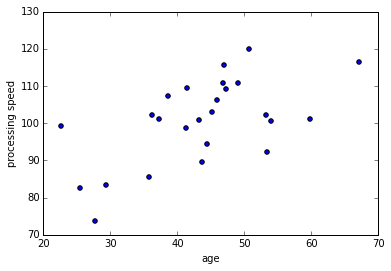

In [72]:
import numpy
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats

def make_continuous_data(mean=[45,100],var=[10,10],cor=0.6,N=100):
    """
    generate a synthetic data set with two variables
    """
    cor=numpy.array([[1.,cor],[cor,1.]])
    var=numpy.array([[var[0],0],[0,var[1]]])
    cov=var.dot(cor).dot(var)
    return numpy.random.multivariate_normal(mean,cov,N)

n=25
d=make_continuous_data(N=n)
plt.scatter(d[:,0],d[:,1])
plt.xlabel('age')
plt.ylabel('processing speed')

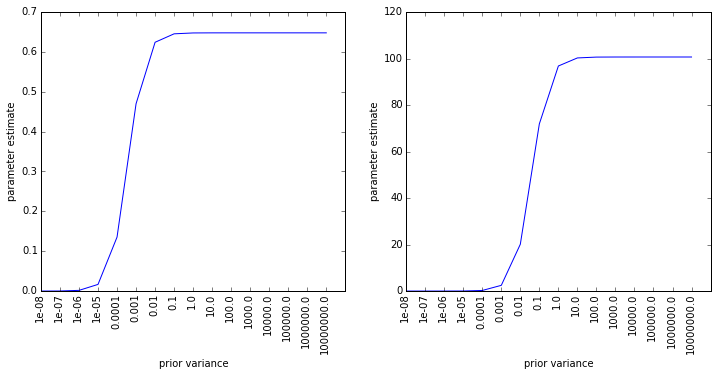

In [78]:
y=d[:,1]
X=numpy.vstack((d[:,0]-numpy.mean(d[:,0]),numpy.ones(d.shape[0]))).T

priorvals=10.**numpy.arange(-8,8)

bhat_glm=numpy.zeros((len(priorvals),2))
bhat_bayes=numpy.zeros((len(priorvals),2))

for i in range(len(priorvals)):
    prior_variance=priorvals[i]
    v=numpy.identity(2)*prior_variance 

    bhat_glm[i,:]=numpy.linalg.inv(X.T.dot(X)).dot(X.T.dot(y))
    bhat_bayes[i,:]=numpy.linalg.inv(X.T.dot(X) + numpy.linalg.inv(v)).dot(X.T.dot(y))

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(range(len(priorvals)),bhat_bayes[:,0])
plt.xticks(range(len(priorvals)),priorvals, rotation='vertical')
plt.xlabel('prior variance')
plt.ylabel('parameter estimate')
plt.subplot(122)
plt.plot(range(len(priorvals)),bhat_bayes[:,1])
plt.xticks(range(len(priorvals)),priorvals, rotation='vertical')
plt.xlabel('prior variance')
plt.ylabel('parameter estimate')


Now let's see what happens as we turn up the prior variance

In [69]:
bhat_glm

array([[  -0.58457666,  103.20088118],
       [  -0.58457666,  103.20088118],
       [  -0.58457666,  103.20088118],
       [  -0.58457666,  103.20088118],
       [  -0.58457666,  103.20088118],
       [  -0.58457666,  103.20088118],
       [  -0.58457666,  103.20088118],
       [  -0.58457666,  103.20088118],
       [  -0.58457666,  103.20088118],
       [  -0.58457666,  103.20088118],
       [  -0.58457666,  103.20088118],
       [  -0.58457666,  103.20088118],
       [  -0.58457666,  103.20088118],
       [  -0.58457666,  103.20088118],
       [  -0.58457666,  103.20088118],
       [  -0.58457666,  103.20088118]])

In [59]:
priorvals

array([  1.00000000e-05,   1.00000000e-04,   1.00000000e-03,
         1.00000000e-02,   1.00000000e-01,   1.00000000e+00,
         1.00000000e+01,   1.00000000e+02,              inf])